![image info](BCI.png)

# Classification of brain states (FOOT and HAND Movement) framework
--------------------------------------------------------------------------------------------------------------------------------

### Data
i. The framework uses the dataset of healthy control subjects performing imagery right and left hand movement.

ii. The total number of signals corresponds to RIGHT HAND MOVEMENT is 500000 while for RIGHT FOOT MOVEMENT it was 400000. 

iii. Each class has 118 channels.

iv. Initial sampling rate = 1KHz, i.e. 1000 samples are captured in one second.

v. The data is downsampled to 100 Hz,  i.e. 100 samples in one second.

## Import required libraries (Note import is repeated to understand the required libraries are imported when specific module is implemented)

In [1]:
# Importing required libraries required to execution
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline
import scipy.io
import warnings
warnings.filterwarnings('ignore') # ignoring warnings if any just to avoid confusion during the execution

### Load the data stored in .MAT file and assign respective classes

In [2]:
# Load the data which is stored in MAT file
BCI_data = scipy.io.loadmat('data/bci.mat')
RH = BCI_data['rh'] # Signals belonging to right hand (RH) movement
RF = BCI_data['rf'] # Signals belonging to right foot (RF) movement

In [3]:
# Find NaN values in matrix2
nan_mask = np.isnan(RF)  # Boolean mask where NaNs are present

# Get row and column indices of NaNs
nan_positions = np.argwhere(nan_mask)  # Returns list of (row, col) positions

# Find which columns contain NaNs
nan_columns = np.where(np.any(nan_mask, axis=0))[0]  # Columns with NaN values

# Print results
# Print results
print(f"NaN values found in {len(nan_positions)} locations.")
print(f"Columns with NaN values: {nan_columns.tolist()}")
print(f"First 10 NaN positions (row, col): {nan_positions[:10].tolist()}")  # Show first 10 for brevity

NaN values found in 0 locations.
Columns with NaN values: []
First 10 NaN positions (row, col): []


In [4]:
# Function to impute NaN values with column mean (for median imputation just replace nanmedian)
def impute_with_mean(matrix):
    # Find NaN values
    nan_mask = np.isnan(matrix)
    
    # Calculate column means (ignoring NaNs)
    col_means = np.nanmedian(matrix, axis=0)
    
    # Replace NaNs with corresponding column mean
    matrix[nan_mask] = np.take(col_means, np.where(nan_mask)[1])
    
    return matrix

# Impute NaN values in both matrix1 and matrix2
RH = impute_with_mean(RH)
RF = impute_with_mean(RF)

### Verify if there are nan values

In [5]:
# Find NaN values in matrix2
nan_mask = np.isnan(RF)  # Boolean mask where NaNs are present

# Get row and column indices of NaNs
nan_positions = np.argwhere(nan_mask)  # Returns list of (row, col) positions

# Find which columns contain NaNs
nan_columns = np.where(np.any(nan_mask, axis=0))[0]  # Columns with NaN values

# Print results
# Print results
print(f"NaN values found in {len(nan_positions)} locations.")
print(f"Columns with NaN values: {nan_columns.tolist()}")
print(f"First 10 NaN positions (row, col): {nan_positions[:10].tolist()}")  # Show first 10 for brevity

NaN values found in 0 locations.
Columns with NaN values: []
First 10 NaN positions (row, col): []


In [6]:
from scipy.stats import mode
### Code for mode-based imputation
def impute_with_mode(matrix):
    # Find NaN values
    nan_mask = np.isnan(matrix)

    # Calculate column mode (ignoring NaNs)
    col_modes = np.array([mode(matrix[:, i], nan_policy='omit').mode[0] for i in range(matrix.shape[1])])

    # Replace NaNs with corresponding column mode
    matrix[nan_mask] = np.take(col_modes, np.where(nan_mask)[1])

    return matrix

# Usage
# RH = impute_with_mode(RH)
# RF = impute_with_mode(RF)

### Preprocessing using filtering

In [7]:
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(data, lowcut, highcut, fs, order=7):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def notch_filter(data, notch_freq, fs, quality_factor=20):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    y = filtfilt(b, a, data)
    return y

fs = 200  # sampling frequency in Hz
# Apply notch filter to suppress 50 Hz signal
filtered_RF = notch_filter(RF, 50, fs)
filtered_RH = notch_filter(RH, 50, fs)

# Apply bandpass filter between 0.5-30 Hz
filtered_signal_RF = bandpass_filter(filtered_RF, 0.5, 30, fs)
filtered_signal_RH = bandpass_filter(filtered_RH, 0.5, 30, fs)

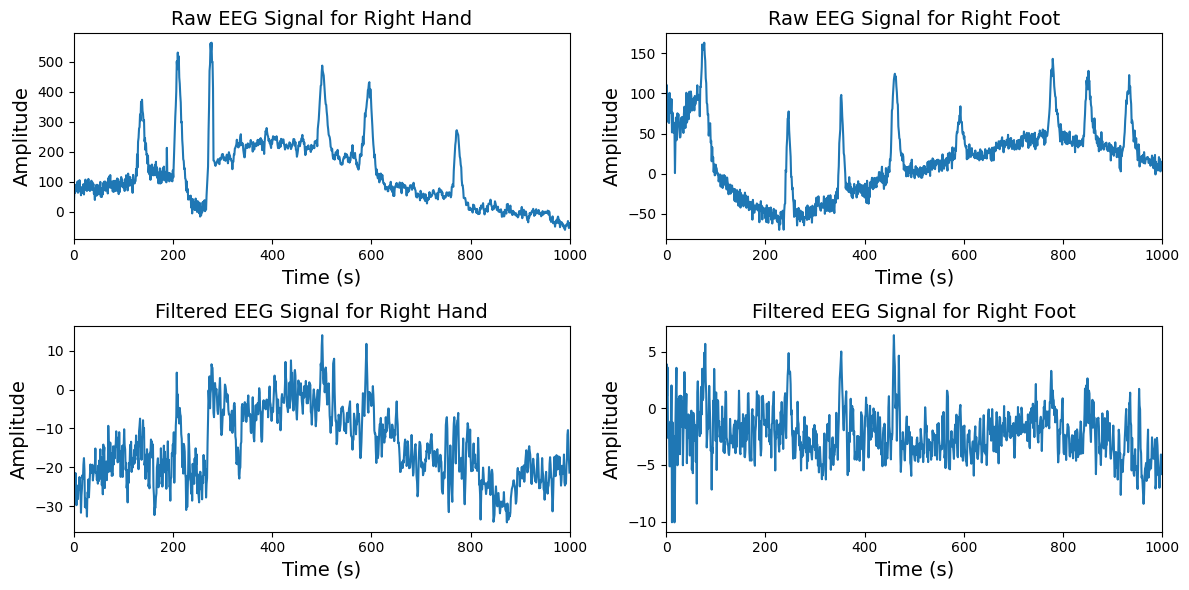

In [8]:
# Plot the raw and filtered signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 2)
plt.plot(RF[5000:6000,0])
plt.title('Raw EEG Signal for Right Foot', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.xlim(0, 1000)

plt.subplot(2, 2, 4)
plt.plot(filtered_signal_RF[5000:6000,0])
plt.title('Filtered EEG Signal for Right Foot', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.xlim(0, 1000)

plt.subplot(2, 2, 1)
plt.plot(RH[5000:6000,0])
plt.title('Raw EEG Signal for Right Hand', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.xlim(0, 1000)

plt.subplot(2, 2, 3)
plt.plot(filtered_signal_RH[5000:6000,0])
plt.title('Filtered EEG Signal for Right Hand', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

plt.xlim(0, 1000)

plt.tight_layout()
#plt.savefig('output/figures/filtered_signals.png')
plt.show()
plt.close()


### Select any one channel for analysis and reshape the data into 10 second long epoch

#### Final obtained signal

i. 400 signals belongs to right hand class

ii. 500 signals belongs to right foot class

iii. Therefore, a total of 900 signals for right hand and right foot

In [9]:
num_channels = 20

# Reshape the data and only select any one channel for simplicity
Right_hand = filtered_signal_RH[:,0:20] # Select any one channel but not the channel should be same for RH and RF
Right_foot = filtered_signal_RF[:,0:20] # Select any one channel but not the channel should be same for RH and RF


Right_hand = Right_hand.reshape(400, 1000, num_channels) # Reshape the right hand data of second channel into 10 second (100 Hz *10 sec)
Right_foot = Right_foot.reshape(500, 1000, num_channels) # Reshape the right foot data of second channel into 10 second (100 Hz *10 sec)


### Now create a binary labels indicating RH and RF

In [10]:
Y = np.concatenate((np.zeros(400), np.ones(500)), axis=0) 
X = np.concatenate((Right_hand,Right_foot)) # 0 indicate RH and 1 indicate RF

## This section indicate feature extraction 

## Wavelet Entropy

In [11]:
import numpy as np
import pywt
from scipy.stats import entropy

def wavelet_entropy(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    energies = np.array([np.sum(np.square(c)) for c in coeffs])
    total_energy = np.sum(energies)
    probs = energies / total_energy
    we = entropy(probs)
    
    return {'Wavelet Entropy': we}

num_signals = X.shape[0]
wavelet_features = [[wavelet_entropy(X[i, :, ch].astype(np.float64)) for ch in range(num_channels)] for i in range(num_signals)]

## Wavelet Coefficients (Per level)

In [12]:
def wavelet_energy_per_level(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = {}
    c_len = len(coeffs)
    for i, c in enumerate(coeffs):
        energy = np.sum(np.square(c))
        if i == 0:
            features[f'Wavelet Energy cA{c_len - 1}'] = energy  
        else:  
            features[f'Wavelet Energy cD{c_len - i}'] = energy
    return features

wavelet_energy_features = [[wavelet_energy_per_level(X[i, :, ch].astype(np.float64)) for ch in range(num_channels)] for i in range(num_signals)]
print()

# L0 is approximatly
#Coefficient	Type	    Frequency Band (approx.)
# --------------------------------------------------#
# cA4	    Approximation	Lowest frequencies
# cD4	    Detail	        Low-mid frequencies
# cD3   	Detail	        Mid frequencies
# cD2	    Detail	        Mid-high frequencies
# cD1	    Detail	        Highest frequencies
# --------------------------------------------------#

## Hilbert-Huang Transform Features

In [13]:
from PyEMD import EMD
from scipy.signal import hilbert

imfs_list = []
envelopes = []
frequencies = []

def hilbert_huang_features(signal):
    emd = EMD()
    imfs = emd(signal)
    features = {}

    for i, imf in enumerate(imfs[:3]):  # Limit to first few IMFs
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_freq = np.diff(instantaneous_phase)

        features[f'IMF{i+1} Mean Amplitude'] = np.mean(amplitude_envelope)
        features[f'IMF{i+1} Mean Frequency'] = np.mean(instantaneous_freq) if len(instantaneous_freq) else 0

        imfs_list.append(imf)
        envelopes.append(amplitude_envelope)
        frequencies.append(instantaneous_freq)

    return features

hilbert_features = [[hilbert_huang_features(X[i, :, ch].astype(np.float64)) for ch in range(num_channels)] for i in range(num_signals)]

## Plot Hilbert Features

<function matplotlib.pyplot.show(close=None, block=None)>

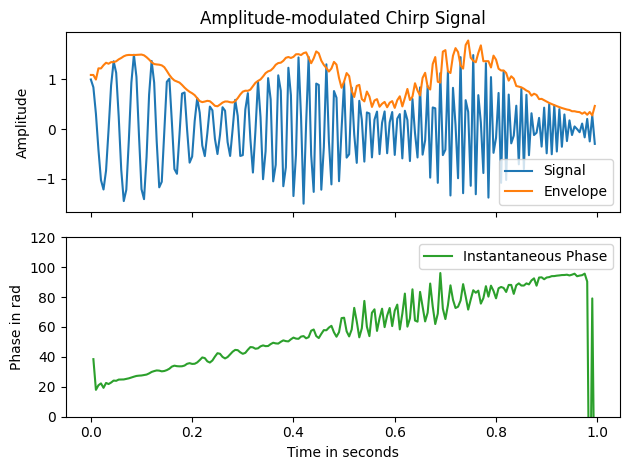

In [14]:
from scipy.signal import chirp

duration, fs = 1, 200  # 1 s signal with sampling frequency of 400 Hz
t = np.arange(int(fs*duration)) / fs  # timestamps of samples
signal = chirp(t, 20.0, t[-1], 100.0)
signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )
emd = EMD()
imfs = emd(signal)
features = {}
analytic_signal = hilbert(imfs[0])
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * fs

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex='all', tight_layout=True)
ax0.set_title("Amplitude-modulated Chirp Signal")
ax0.set_ylabel("Amplitude")
ax0.plot(t, signal, label='Signal')
ax0.plot(t, amplitude_envelope, label='Envelope')
ax0.legend()
ax1.set(xlabel="Time in seconds", ylabel="Phase in rad", ylim=(0, 120))
ax1.plot(t[1:], instantaneous_frequency, 'C2-', label='Instantaneous Phase')
ax1.legend()
plt.show

## Plot Wavelet Decomposition

131


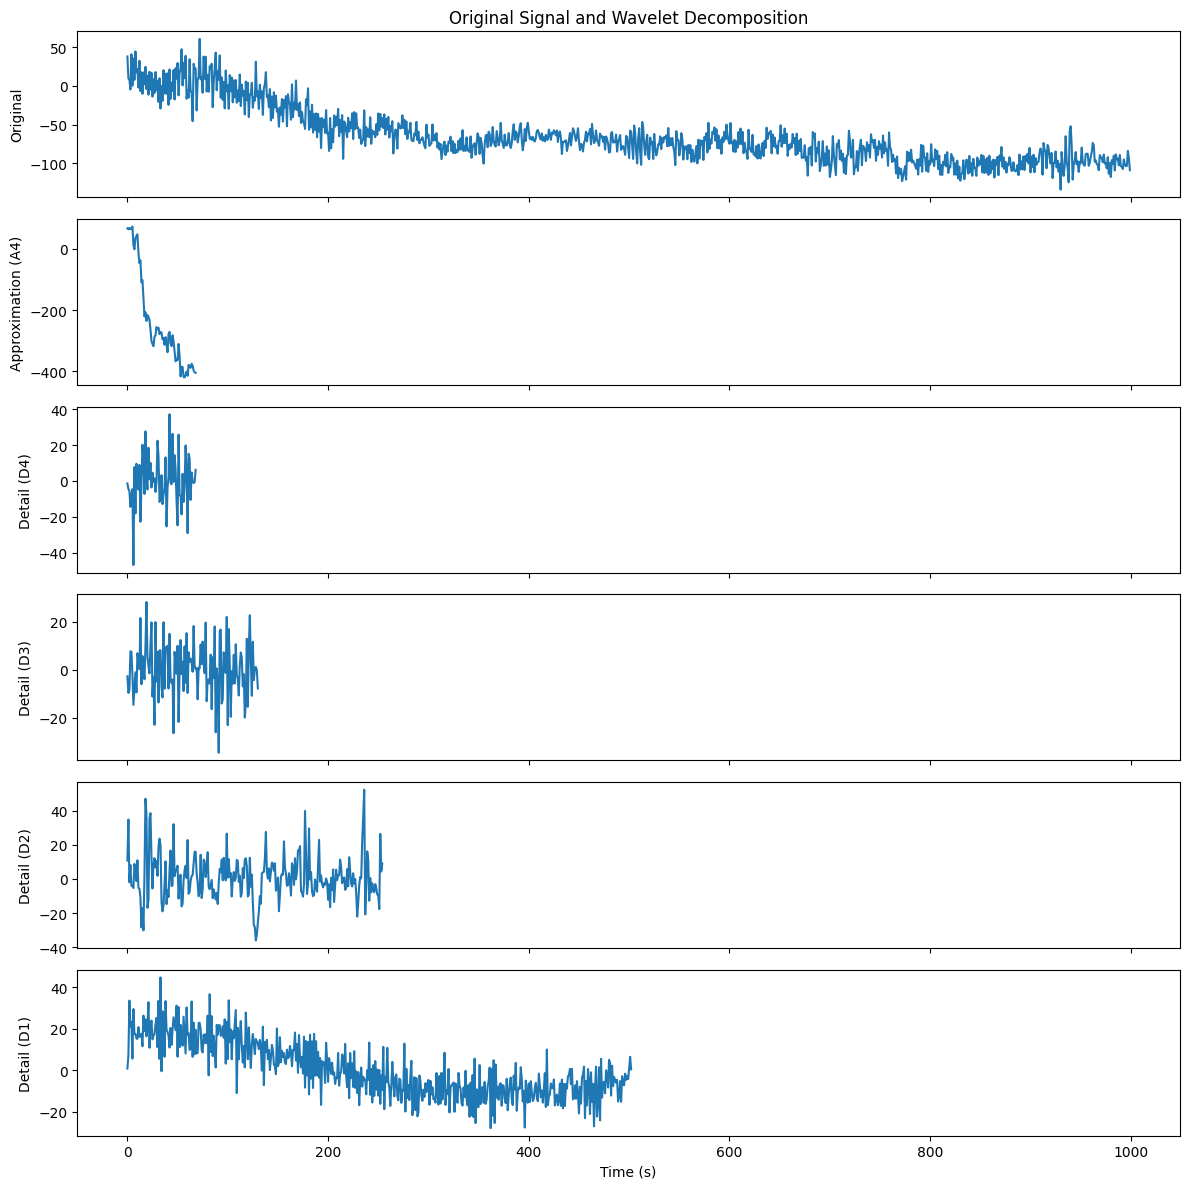

131


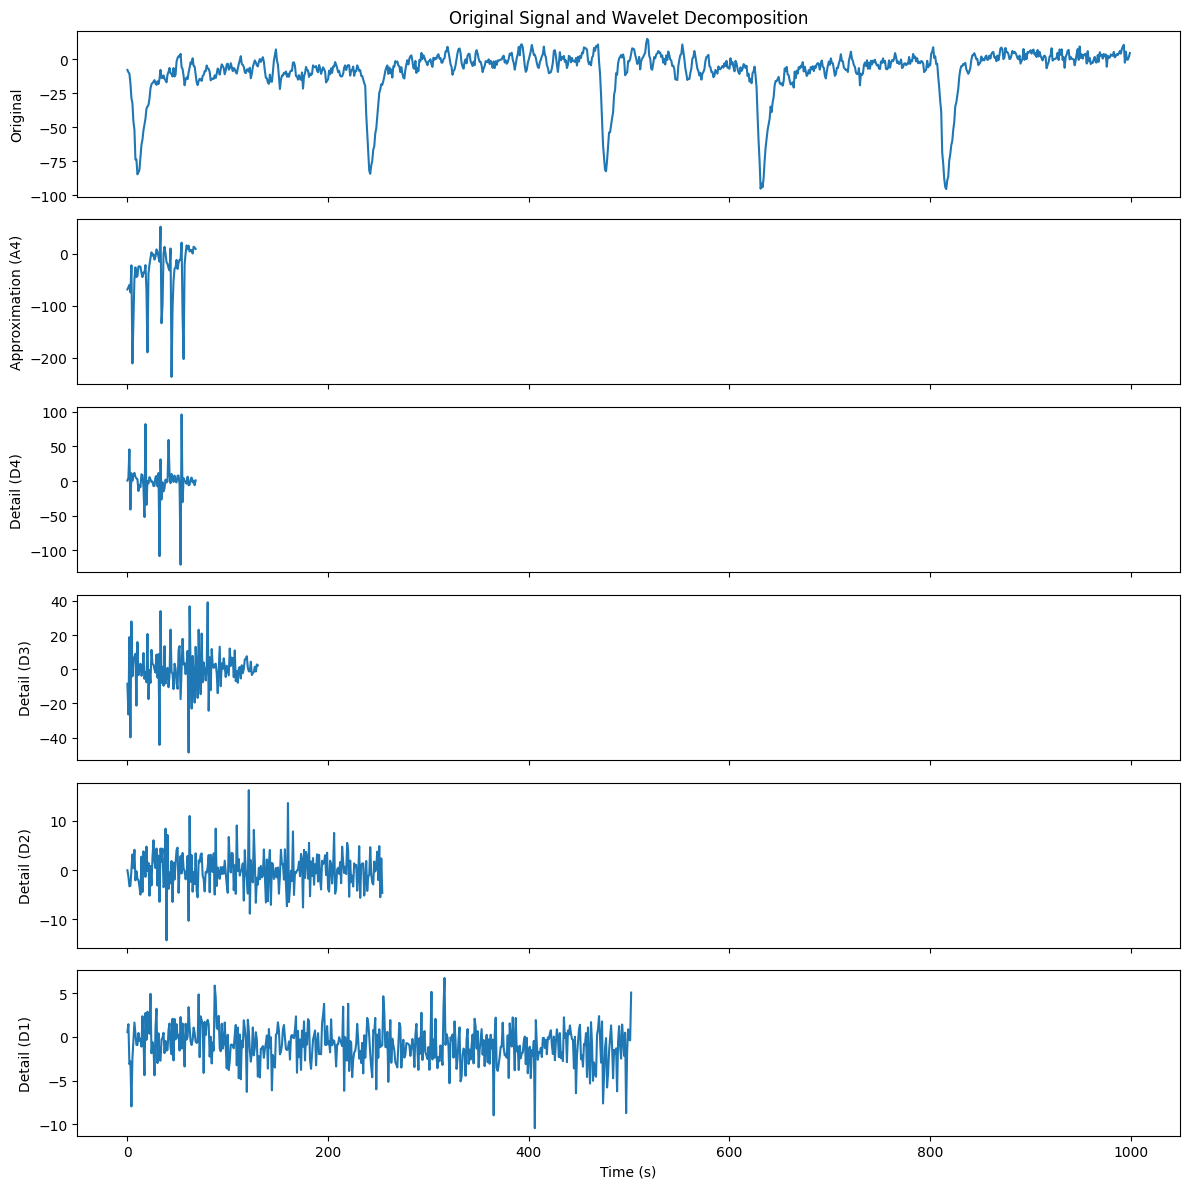

In [15]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def plot_wavelet_decomposition(signal, wavelet='db4', level=4, sampling_rate=None):
    """
    Plots the original signal and its wavelet decomposition coefficients.
    
    Parameters:
    - signal: 1D array-like
    - wavelet: str, wavelet name (e.g., 'db4')
    - level: int, number of decomposition levels
    - sampling_rate: int or float, optional (for time axis)
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    labels = [f'Approximation (A{level})'] + [f'Detail (D{l})' for l in range(level, 0, -1)]
    
    n_subplots = len(coeffs) + 1  # +1 for original signal
    fig, axes = plt.subplots(n_subplots, 1, figsize=(12, 2 * n_subplots), sharex=True)
    print(len(coeffs[2]))
    # Time axis
    time = np.arange(len(signal)) / sampling_rate if sampling_rate else np.arange(len(signal))
    
    # Original signal
    axes[0].plot(signal[:])
    axes[0].set_ylabel("Original")
    axes[0].set_title("Original Signal and Wavelet Decomposition")
    
    # Plot coefficients
    for i, (c, label) in enumerate(zip(coeffs, labels)):
        axes[i + 1].plot(c)
        axes[i + 1].set_ylabel(label)
        

    axes[-1].set_xlabel("Samples" if sampling_rate is None else "Time (s)")
    
    plt.tight_layout()
    plt.show()


# Assuming X is your data array with shape (900, 1000, 10)
plot_wavelet_decomposition(X[230, :, 9], wavelet='db4', level=4, sampling_rate=0.1)
plot_wavelet_decomposition(X[700, :, 9], wavelet='db4', level=4, sampling_rate=0.1)



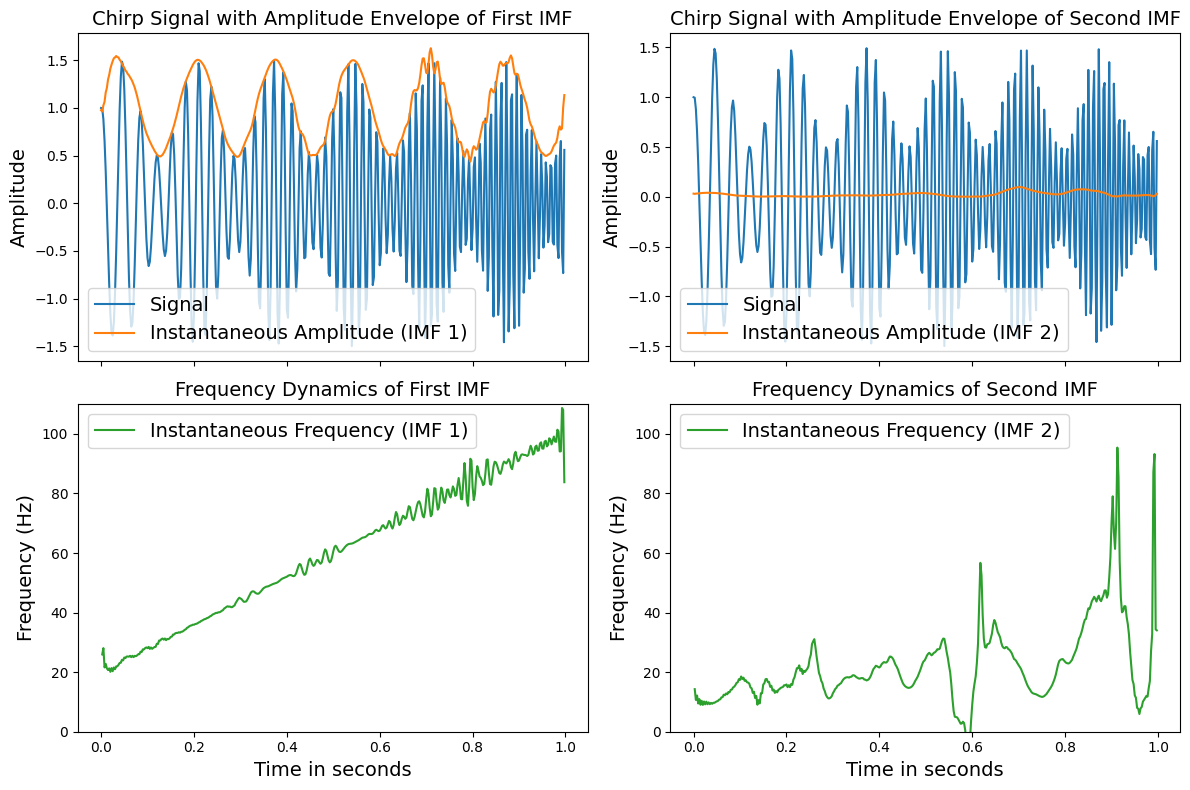

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
from PyEMD import EMD

# Signal setup
duration, fs = 1, 400  # 1 s, 400 Hz sampling
t = np.arange(int(fs * duration)) / fs
signal = chirp(t, 20.0, t[-1], 100.0)
signal *= (1.0 + 0.5 * np.sin(4.0 * np.pi * 3.0 * t))

# Empirical Mode Decomposition
emd = EMD()
imfs = emd(signal)

# IMF 0
analytic_signal_emd = hilbert(imfs[0])
amplitude_envelope_emd = np.abs(analytic_signal_emd)
instantaneous_phase_emd = np.unwrap(np.angle(analytic_signal_emd))
instantaneous_frequency_emd = np.diff(instantaneous_phase_emd) / (2.0 * np.pi) * fs

# IMF 1
analytic_signal = hilbert(imfs[1])
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs

# Plot
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    nrows=2, ncols=2, sharex='all', tight_layout=True, figsize=(12, 8)
)

# ax0 - IMF 0 Amplitude
ax0.set_title("Chirp Signal with Amplitude Envelope of First IMF", fontsize=14)
ax0.set_ylabel("Amplitude", fontsize=14)
ax0.plot(t, signal, label='Signal')
ax0.plot(t, amplitude_envelope_emd, label='Instantaneous Amplitude (IMF 1)')
ax0.legend(loc='lower left', fontsize=14)

# ax1 - IMF 1 Amplitude
ax1.set_title("Chirp Signal with Amplitude Envelope of Second IMF", fontsize=14)
ax1.set_ylabel("Amplitude", fontsize=14)
ax1.plot(t, signal, label='Signal')
ax1.plot(t, amplitude_envelope, label='Instantaneous Amplitude (IMF 2)')
ax1.legend(loc='lower left', fontsize=14)

# ax2 - IMF 0 Frequency
ax2.set_title("Frequency Dynamics of First IMF", fontsize=14)
ax2.set_xlabel("Time in seconds", fontsize=14)
ax2.set_ylabel("Frequency (Hz)", fontsize=14)
ax2.set_ylim(0, 110)
ax2.plot(t[1:], instantaneous_frequency_emd, 'C2-', label='Instantaneous Frequency (IMF 1)')
ax2.legend(loc='upper left', fontsize=14)

# ax3 - IMF 1 Frequency
ax3.set_title("Frequency Dynamics of Second IMF", fontsize=14)
ax3.set_xlabel("Time in seconds", fontsize=14)
ax3.set_ylabel("Frequency (Hz)", fontsize=14)
ax3.set_ylim(0, 110)
ax3.plot(t[1:], instantaneous_frequency, 'C2-', label='Instantaneous Frequency (IMF 2)')
ax3.legend(loc='upper left', fontsize=14)

plt.savefig('IMF_analysis.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

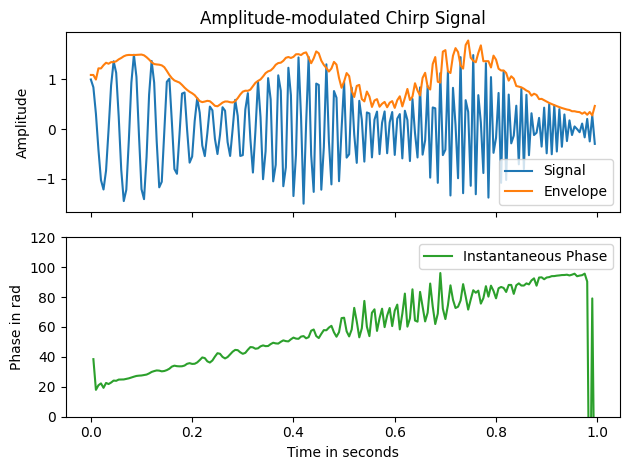

In [17]:
duration, fs = 1, 200  # 1 s signal with sampling frequency of 400 Hz
t = np.arange(int(fs*duration)) / fs  # timestamps of samples
signal = chirp(t, 20.0, t[-1], 100.0)
signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )
# signal = X[1, :, 0]

# signal = X[509, :200, 0]          # X[1, :200, 0] - left hand
# N = len(signal)

emd = EMD()
imfs = emd(signal)
features = {}

analytic_signal = hilbert(imfs[0])
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * fs

window_size = 20
#smooth_freq = np.convolve(instantaneous_frequency, np.ones(window_size)/window_size, mode='same')
# FIGURE SUBPLOT
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex='all', tight_layout=True)
ax0.set_title("Amplitude-modulated Chirp Signal")
ax0.set_ylabel("Amplitude")
ax0.plot(t, signal, label='Signal')
ax0.plot(t, amplitude_envelope, label='Envelope')
#ax0.set_xlim(0, 0.5)
ax0.legend()
ax1.set(xlabel="Time in seconds", ylabel="Phase in rad", ylim=(0, 120))
ax1.plot(t[1:], instantaneous_frequency, 'C2-', label='Instantaneous Phase')
ax1.legend()
plt.show

### Feature concatenation 

In [18]:
# Combine all features into a single DataFrame
def combine_features(stat_features, time_features, freq_features):
    combined_features_list = []
    for i in range(len(stat_features)):
        combined_features = {**stat_features[i], **time_features[i], **freq_features[i]}
        combined_features_list.append(combined_features)
    return pd.DataFrame(combined_features_list)
    #return combined_features_list

# Flatten features for all signals and channels
combined_features_df = []
for signal in range(num_signals):  # Iterate over signals
    for channel in range(num_channels):  # Iterate over channels
        # Combine features for each signal-channel pair
        combined_temp = combine_features(
            [wavelet_features[signal][channel]],  # Wrap in a list to match the function's input format
            [wavelet_energy_features[signal][channel]],
            [hilbert_features[signal][channel]]
        )
        combined_features_df.append(combined_temp)
combined_features_df = pd.concat(combined_features_df, ignore_index=True)

print("Combined Features DataFrame:")
combined_features_df

Combined Features DataFrame:


,Wavelet Entropy,Wavelet Energy cA4,Wavelet Energy cD4,Wavelet Energy cD3,Wavelet Energy cD2,Wavelet Energy cD1,IMF1 Mean Amplitude,IMF1 Mean Frequency,IMF2 Mean Amplitude,IMF2 Mean Frequency,IMF3 Mean Amplitude,IMF3 Mean Frequency
0,0.279859,8.389962e+05,5880.983409,7789.050204,15527.146967,1.877517e+04,5.002506,1.243152,4.638025,1.061071,3.072621,0.540129
1,1.057120,6.012185e+05,33903.574846,142406.238865,33313.106790,9.387886e+05,30.568158,0.267461,7.509370,1.237881,7.165207,0.585895
2,1.019000,2.144326e+06,70349.089440,304375.242792,67926.150267,2.109171e+06,45.760444,0.235952,10.284439,1.283156,9.778365,0.615152
3,0.519207,1.026871e+07,56818.820277,218006.804307,61038.155174,1.474861e+06,38.271889,0.198228,10.437908,1.208255,8.259032,0.615074
4,0.084622,2.773811e+07,24770.850798,50627.997233,35602.940469,2.732887e+05,16.740592,0.569632,7.631078,1.199595,6.399082,0.610230
...,...,...,...,...,...,...,...,...,...,...,...,...
17995,0.775240,2.157385e+06,11763.851374,20124.628548,31687.649202,2.039853e+06,48.943895,0.443880,5.459359,1.086348,4.667012,0.584405
17996,0.743417,3.054255e+06,13871.460219,20115.512004,30297.860046,1.999613e+06,48.437944,0.481621,4.836050,1.142994,4.833669,0.584084
17997,0.771920,2.479527e+06,15815.031343,21946.140444,32078.120459,1.957937e+06,47.890882,0.469049,4.880216,1.262324,5.209826,0.596592
17998,0.766274,9.777017e+05,15610.967146,23500.539017,35449.744455,1.923777e+06,47.462993,0.412449,4.682608,1.319076,5.738152,0.634361


# Normalize

In [19]:
from sklearn.preprocessing import StandardScaler
# Create DataFrame
df = pd.DataFrame(combined_features_df)

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to normalize the data
normalized_data = scaler.fit_transform(df)

# NEW
columns = df.columns
# 

# Convert the result back into a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=columns)  # combined_features_df.columns
normalized_df

,Wavelet Entropy,Wavelet Energy cA4,Wavelet Energy cD4,Wavelet Energy cD3,Wavelet Energy cD2,Wavelet Energy cD1,IMF1 Mean Amplitude,IMF1 Mean Frequency,IMF2 Mean Amplitude,IMF2 Mean Frequency,IMF3 Mean Amplitude,IMF3 Mean Frequency
0,0.026795,-0.176180,-0.222227,-0.303816,-0.321267,-0.287395,-0.397381,0.465148,-0.426556,0.426056,-0.532976,1.027034
1,2.970904,-0.179445,-0.149934,0.328673,-0.240788,-0.276258,-0.224562,-1.506353,0.130609,1.644474,0.044362,1.652455
2,2.826514,-0.158256,-0.055912,1.089673,-0.084170,-0.262091,-0.121865,-1.570022,0.669093,1.956473,0.412998,2.052267
3,0.933395,-0.046694,-0.090818,0.683877,-0.115337,-0.269769,-0.172487,-1.646246,0.698873,1.440318,0.198667,2.051198
4,-0.712726,0.193190,-0.173495,-0.102541,-0.230427,-0.284314,-0.318034,-0.895780,0.154226,1.380639,-0.063715,1.985010
...,...,...,...,...,...,...,...,...,...,...,...,...
17995,1.903199,-0.158076,-0.207050,-0.245859,-0.248143,-0.262930,-0.100346,-1.149878,-0.267182,0.600241,-0.308057,1.632090
17996,1.782659,-0.145761,-0.201613,-0.245901,-0.254432,-0.263417,-0.103766,-1.073617,-0.388131,0.990596,-0.284547,1.627712
17997,1.890620,-0.153653,-0.196599,-0.237300,-0.246376,-0.263921,-0.107464,-1.099021,-0.379561,1.812913,-0.231482,1.798637
17998,1.869235,-0.174275,-0.197126,-0.229997,-0.231120,-0.264335,-0.110357,-1.213387,-0.417905,2.204000,-0.156952,2.314768


# Select which feature to work on

In [80]:
selected_data = normalized_data.copy()

sel_range = np.arange(0,6)

# Select the wanted data
selected_data = selected_data[:,sel_range]
sel_columns = normalized_df.columns[sel_range] 

# If shape is has one feature
if len(selected_data.shape) == 1:
    sel_normalized_data = selected_data.reshape(-1, 1)
else:
    sel_normalized_data = selected_data

sel_normalized_df = pd.DataFrame(sel_normalized_data, columns=sel_columns)

normalized_data = selected_data.copy()
normalized_df = sel_normalized_df.copy()


## Kruskal-Wallis test

In [170]:
# Perform Kruskal-Wallis test
''' Old code
class0_start_idx = 0
class0_end_idx = 400

class1_start_idx = class0_end_idx
class1_end_idx = 900

for ch in range(2):
    kruskal_results = {}
    

    for feature in normalized_df.columns:
        #class_0 = normalized_df[feature][:400*num_channels]
        #class_1 = normalized_df[feature][400*num_channels:]
        class_0 = normalized_df[feature][class0_start_idx:class0_end_idx]
        class_1 = normalized_df[feature][class1_start_idx:class1_end_idx]
        
        if class_0.nunique() <= 1 or class_1.nunique() <= 1:
            print(f"Skipping feature '{feature}' due to lack of variability.")
            continue
        kruskal_results[feature] = stats.kruskal(class_0, class_1).pvalue

        # Export Kruskal-Wallis test results to Excel
    kruskal_results_df = pd.DataFrame(list(kruskal_results.items()), columns=['Feature', 'P-value'])
    kruskal_results_df.to_excel('kruskal_wallis_results.xlsx', index=False)

    class0_start_idx = class1_end_idx
    class0_end_idx *= 2
    class1_start_idx = class0_end_idx
    class1_end_idx *= 2
print("Kruskal-Wallis test results have been exported to 'kruskal_wallis_results.xlsx'.")'''
import pandas as pd
from scipy import stats
from openpyxl import load_workbook

# Perform Kruskal-Wallis test
output_file = 'kruskal_wallis_results_hilbert.xlsx'  # Define the output file
num_channels = 20  # Total number of channels
samples_per_channel = 900  # Total samples per channel
class0_size = 400  # Number of samples in class 0
class1_size = 500  # Number of samples in class 1

# Collect all results in a single DataFrame
all_results = []


for ch in range(num_channels):  # Loop through all channels
    for feature in normalized_df.columns:
        # Define indices for class 0 and class 1 for the current channel
        channel_start_idx = ch * samples_per_channel
        class0_start_idx = channel_start_idx
        class0_end_idx = class0_start_idx + class0_size
        class1_start_idx = class0_end_idx
        class1_end_idx = class1_start_idx + class1_size

        # Slice the data for class 0 and class 1
        class_0 = normalized_df[feature][class0_start_idx:class0_end_idx]
        class_1 = normalized_df[feature][class1_start_idx:class1_end_idx]

        # Check for variability in the data
        if class_0.nunique() <= 1 or class_1.nunique() <= 1:
            print(f"Skipping feature '{feature}' for channel {ch} due to lack of variability.")
            continue

        # Perform Kruskal-Wallis test and store the p-value
        p_value = stats.kruskal(class_0, class_1).pvalue
        H_value = stats.kruskal(class_0, class_1).statistic
        all_results.append({'Feature': feature, 'Statistical value': H_value, 'P-value': p_value, 'Channel': ch+1})
       

# Convert all results to a DataFrame
results_df = pd.DataFrame(all_results)

# Write the results to the Excel file
results_df.to_excel(output_file, index=False, sheet_name='Results')


(18000,)


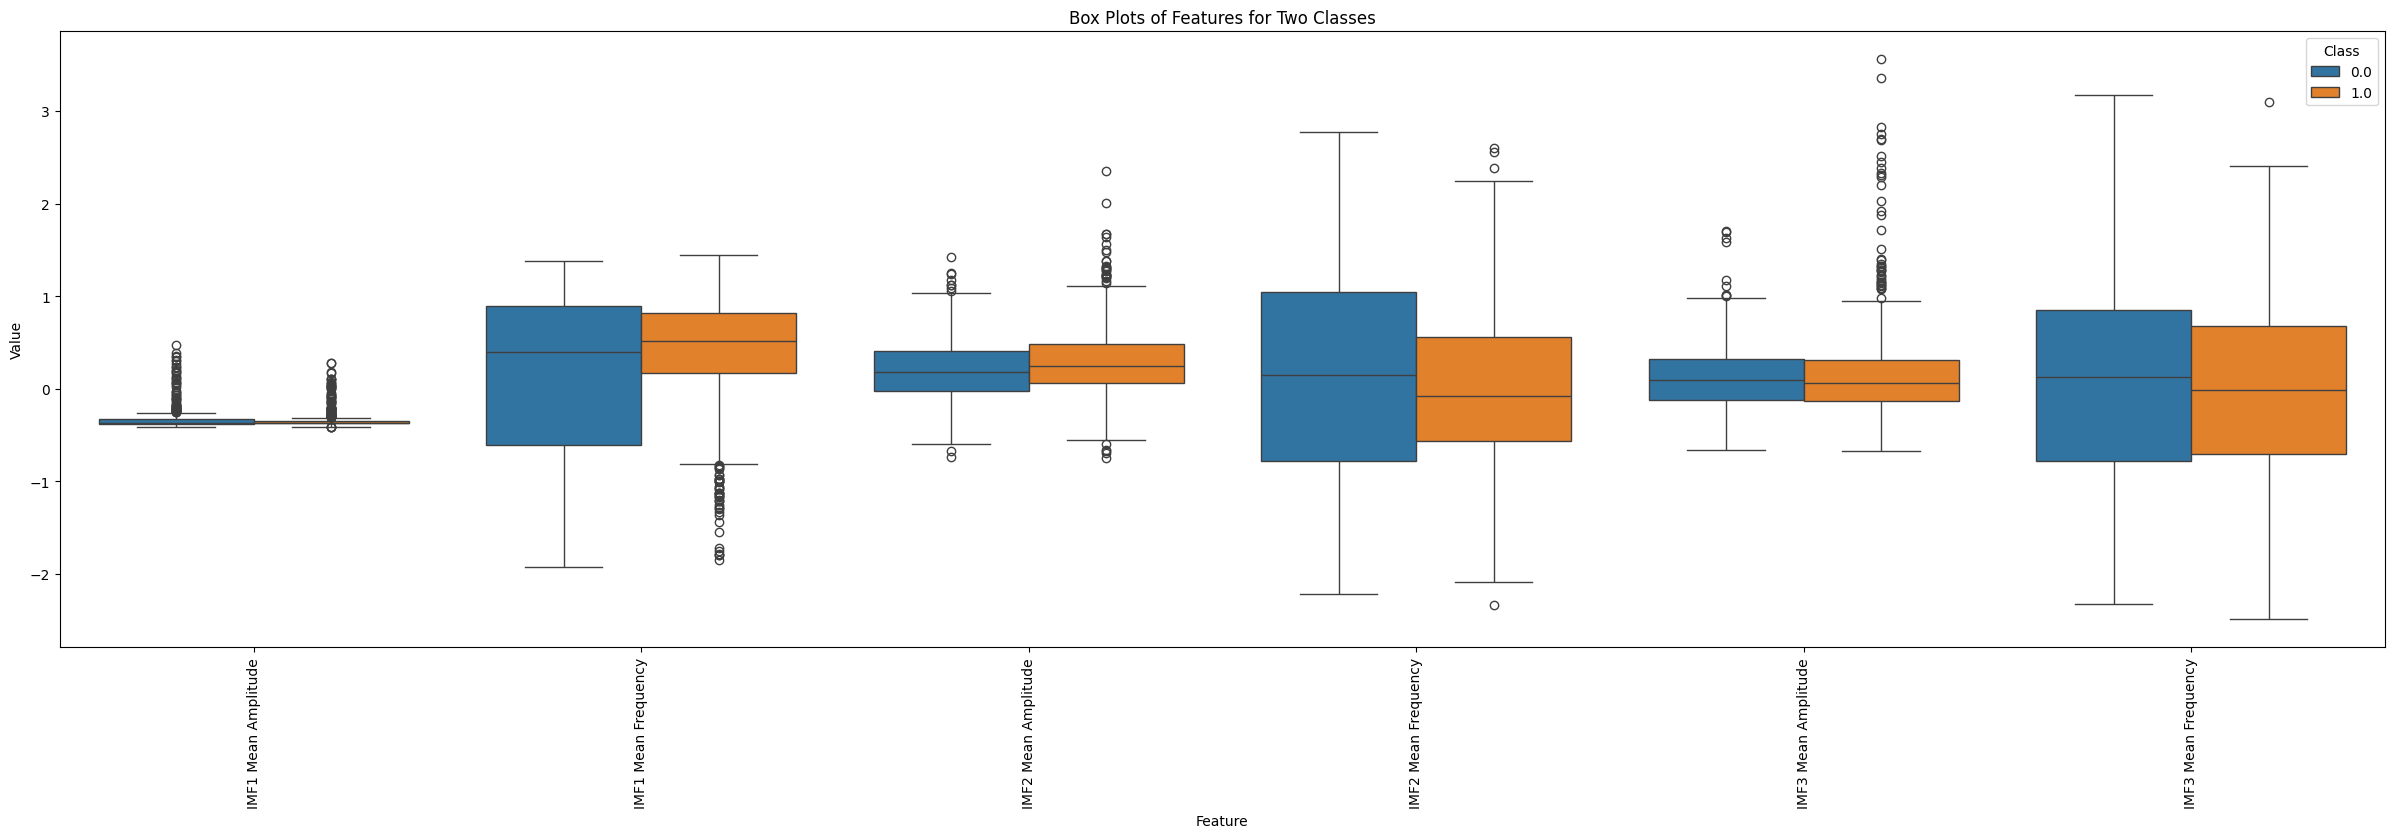

In [ ]:
num_channels = 20
# Plot box plots for each feature
Y_all_channels = np.tile(Y, num_channels)
print(Y_all_channels.shape)
plt.figure(figsize=(30, 8))
sel_normalized_df['Class'] = Y_all_channels
melted_df = pd.melt(sel_normalized_df[900:1800], id_vars='Class', var_name='Feature', value_name='Value')
sns.boxplot(x='Feature', y='Value', hue='Class', data=melted_df)
plt.xticks(rotation=90)
plt.title('Box Plots of Features for Two Classes')
plt.savefig('KW_test')
plt.show()

In [ ]:
900*7

(18000,)


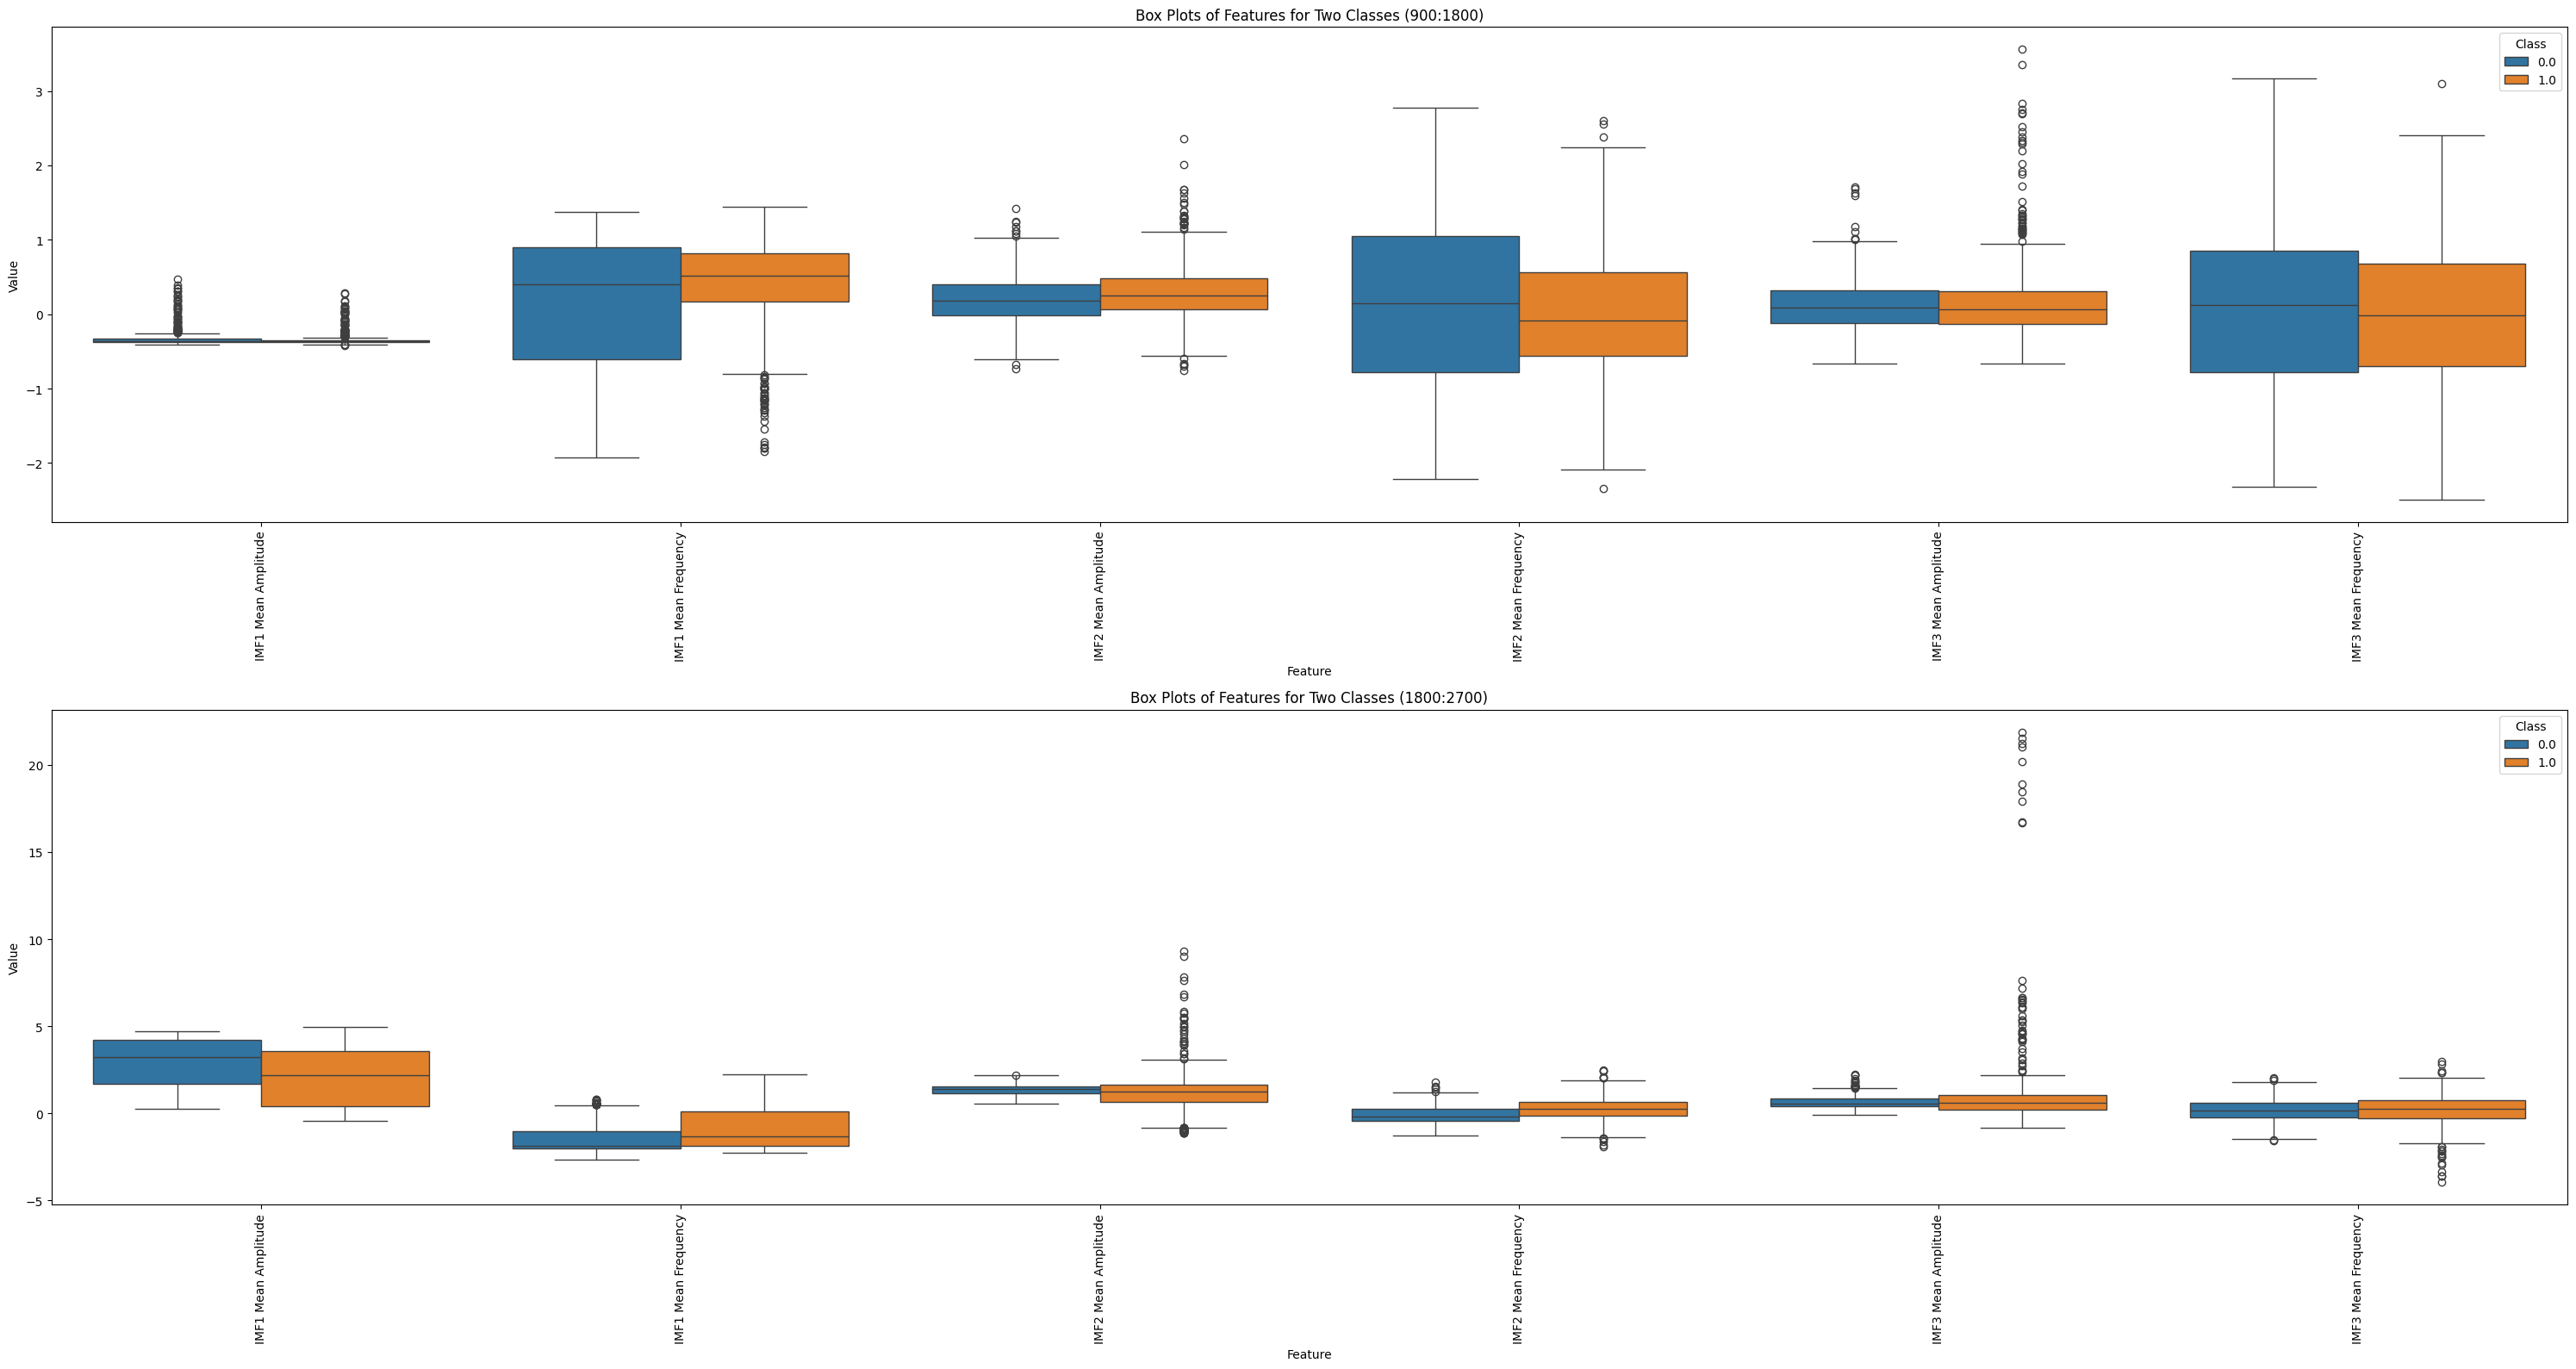

In [175]:
num_channels = 20
# Create Y_all_channels
Y_all_channels = np.tile(Y, num_channels)
print(Y_all_channels.shape)

# Add 'Class' column to the DataFrame
sel_normalized_df['Class'] = Y_all_channels

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(30, 16))  # 2 rows, 1 column

# First subplot: sel_normalized_df[900:1800]
melted_df1 = pd.melt(sel_normalized_df[900:900*7], id_vars='Class', var_name='Feature', value_name='Value')
sns.boxplot(x='Feature', y='Value', hue='Class', data=melted_df1, ax=axes[0])
axes[0].set_title('Box Plots of Features for Two Classes (900:1800)')
axes[0].tick_params(axis='x', rotation=90)

# Second subplot: sel_normalized_df[1800:2700]
melted_df2 = pd.melt(sel_normalized_df[7200:8100], id_vars='Class', var_name='Feature', value_name='Value')
sns.boxplot(x='Feature', y='Value', hue='Class', data=melted_df2, ax=axes[1])
axes[1].set_title('Box Plots of Features for Two Classes (1800:2700)')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('KW_test_subplots')
plt.show()

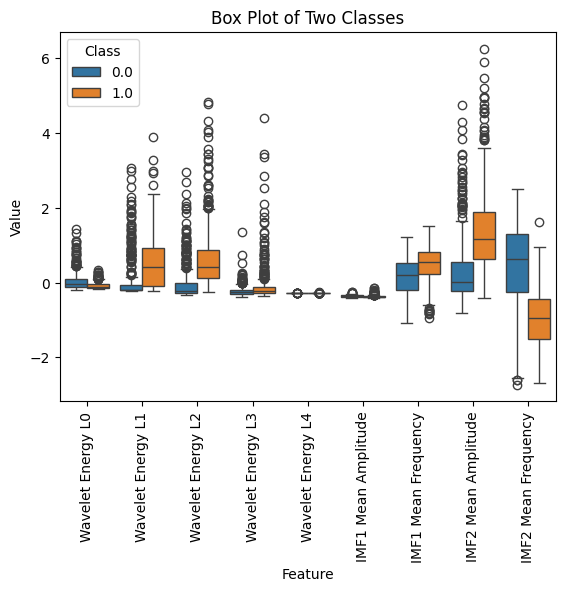

In [63]:
# Filter to include only 'Feature1'
#features_to_plot = ['LZiv Complexity', 'Standard Deviation', 'Min Value', 'Sample Entropy']
features_to_plot = ['Wavelet Energy L0', 'Wavelet Energy L1', 'Wavelet Energy L2',
       'Wavelet Energy L3', 'Wavelet Energy L4', 'IMF1 Mean Amplitude',
       'IMF1 Mean Frequency', 'IMF2 Mean Amplitude', 'IMF2 Mean Frequency']
normalized_df['Class'] = Y_all_channels
melted_df = pd.melt(normalized_df[4500:5400], id_vars='Class', var_name='Feature', value_name='Value')
melted_df = melted_df[melted_df['Feature'].isin(features_to_plot)]
sns.boxplot(x='Feature', y='Value', hue='Class', data=melted_df)
plt.xticks(rotation=90)
plt.title('Box Plot of Two Classes')
plt.savefig('box_plot_feature1.png')
plt.show()

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [85]:
# Initialize the model
model = RandomForestClassifier()

# Initialize RFE with the model and number of features to select
rfe = RFE(model, n_features_to_select=3)

# Fit RFE
rfe = rfe.fit(normalized_df, Y_all_channels)

# Get the selected features
selected_features = normalized_df.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Wavelet Energy cD3', 'Wavelet Energy cD2', 'Wavelet Energy cD1'], dtype='object')


### Classification using SVM (linear and nonlinear)

In [86]:
# Import SVM and train test split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 

In [ ]:
#Simple classification
end_idx = 0
for ch in range(1, num_channels+1):
    st_idx = end_idx
    end_idx = num_signals * ch
    norm_data_split = sel_normalized_data[st_idx:end_idx]
    
    X_train, X_test, y_train, y_test = train_test_split(norm_data_split, Y, test_size=0.3, random_state=42)
    # Suing 70% data for trainig and 30% data for testing

    # Initialize linear and nonlinear SVM models
    linear_svm = SVC(kernel='linear',C=1, probability=True)  # You can change kernel to 'rbf', 'poly', etc.
    nonlinear_svm = SVC(kernel='rbf',C=2, gamma=1,  probability=True)  # You can change kernel to 'rbf', 'poly', etc.

    # Fit the models with the selected features
    linear_svm.fit(X_train, y_train)
    nonlinear_svm.fit(X_train, y_train)

    # Evaluate the models
    linear_score = linear_svm.score(X_test, y_test)
    nonlinear_score = nonlinear_svm.score(X_test, y_test)
    print("Linear SVM Accuracy:", linear_score)
    print("Nonlinear SVM Accuracy:", nonlinear_score)

### Plot Confusion Matrix

In [ ]:
'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plot confusion matrices for both models
y_pred_linear = linear_svm.predict(X_test)
y_pred_nonlinear = nonlinear_svm.predict(X_test)

cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_nonlinear = confusion_matrix(y_test, y_pred_nonlinear)

disp_linear = ConfusionMatrixDisplay(confusion_matrix=cm_linear,
                                     display_labels=['Right hand', 'Right foot'])
disp_nonlinear = ConfusionMatrixDisplay(confusion_matrix=cm_nonlinear,
                                        display_labels=['Right hand', 'Right foot'])

disp_linear.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Linear SVM")
plt.savefig("CM_L_SVM")
plt.show()

disp_nonlinear.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Nonlinear SVM")
plt.savefig("CM_NL_SVM")
plt.show()'''

### Classification Report

In [93]:
'''
from sklearn.metrics import classification_report
report_linear = classification_report(y_test, y_pred_linear, target_names=['Right hand', 'Right foot'])
report_nonlinear = classification_report(y_test, y_pred_nonlinear, target_names=['Right hand', 'Right foot'])
print(report_linear)
print(report_nonlinear)'''

              precision    recall  f1-score   support

  Right hand       0.00      0.00      0.00       121
  Right foot       0.55      1.00      0.71       149

    accuracy                           0.55       270
   macro avg       0.28      0.50      0.36       270
weighted avg       0.30      0.55      0.39       270

              precision    recall  f1-score   support

  Right hand       0.00      0.00      0.00       121
  Right foot       0.55      1.00      0.71       149

    accuracy                           0.55       270
   macro avg       0.28      0.50      0.36       270
weighted avg       0.30      0.55      0.39       270



### ROC AUC Curve

In [ ]:
'''
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_nonlinear)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with detailed annotations

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)'''

### Training with Entire data

In [ ]:
'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(normalized_data, Y, test_size=0.3, random_state=42)
# Suing 70% data for trainig and 30% data for testing

# Initialize linear and nonlinear SVM models
linear_svm = SVC(kernel='linear',C=1, probability=True)  # You can change kernel to 'rbf', 'poly', etc.
nonlinear_svm = SVC(kernel='rbf',C=2, gamma=1,  probability=True)  # You can change kernel to 'rbf', 'poly', etc.

# Fit the models with the selected features
linear_svm.fit(X_train, y_train)
nonlinear_svm.fit(X_train, y_train)

# Evaluate the models
linear_score = linear_svm.score(X_test, y_test)
nonlinear_score = nonlinear_svm.score(X_test, y_test)
print("Linear SVM Accuracy:", linear_score)
print("Nonlinear SVM Accuracy:", nonlinear_score)
'''

In [245]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_test, y_pred):
    '''
    y_pred is svm_model.predict(X_test)
    '''
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve with detailed annotations

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.grid(True)
    plt.savefig('ROC_curve_classification_combined_feature_set.png')

### Validation using 10-fold cross validation

In [39]:
import numpy as np

def average_classification_reports(reports, labels=['Right hand', 'Right foot']):
    """
    Averages precision, recall, f1-score, and accuracy from multiple classification_report dictionaries.
    
    Parameters:
        reports (list): List of dictionaries returned by sklearn's classification_report(..., output_dict=True)
        labels (list): List of class labels used in the classification report

    Returns:
        dict: Dictionary containing the average metrics
    """
    mean_report = {label: {} for label in labels}
    mean_report['macro avg'] = {}
    mean_report['weighted avg'] = {}

    for label in labels + ['macro avg', 'weighted avg']:
        for metric in ['precision', 'recall', 'f1-score']:
            values = [r[label][metric] for r in reports]
            mean_report[label][metric] = round(np.mean(values)*100, 2)

    # Accuracy is a separate top-level key
    accuracies = [r['accuracy'] for r in reports]
    mean_report['accuracy'] = round(np.mean(accuracies)*100, 2)

    return mean_report



In [87]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.svm import SVC 

# Define SVM classifier
svm_model = SVC(kernel='rbf',C=0.3, gamma=0.3,  probability=True)  # You can change kernel to 'rbf', 'poly', etc.
n_splits = 5
# Define 10-fold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create a plot for ROC
plt.figure(figsize=(12, 8))

T_score = []
T_combined_confusion_matrix = np.zeros((len(np.unique(Y)), len(np.unique(Y))), dtype=int)
channel_metrics = {}
report_nonlinear = {}
roc_data = {}  # Dictionary to store ROC values for channels 9 and 12

end_idx = 0
for ch in range(1, num_channels+1): # num_channels+1
    st_idx = end_idx
    end_idx = num_signals * ch
    norm_data_split = normalized_data[st_idx:end_idx]

    # Initialize a matrix to store the combined confusion matrix
    combined_confusion_matrix = np.zeros((len(np.unique(Y)), len(np.unique(Y))), dtype=int)

    # Initialize lists to store all true labels and predicted probabilities
    y_true_combined = []
    y_pred_prob_combined = []

    score = []

    channel_metrics[ch] = {
        'accuracy': [],
        'confusion_matrix': np.zeros((len(np.unique(Y)), len(np.unique(Y))), dtype=int),
        'classification_report': [],
    }

    # Perform cross-validation manually to access each fold
    for fold, (train_index, test_index) in enumerate(kf.split(norm_data_split), start=1):
        X_train, X_test = norm_data_split[train_index], norm_data_split[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Train the model
        svm_model.fit(X_train, y_train)
        
        # Get probability predictions for ROC curve
        y_prob = svm_model.predict_proba(X_test)
        
        # Append true labels and predicted probabilities to combined lists
        y_true_combined.extend(y_test)
        #y_pred_prob_combined.extend(y_prob)
        y_pred_prob_combined.extend(y_prob)  # assuming binary classification, take prob of class 1

        y_pred = svm_model.predict(X_test)
        
        # Calculate confusion matrix for this fold
        cm = confusion_matrix(y_test, y_pred)
        
        if (ch == 9 or ch == 14 or ch == 17):
            print("---------------------------------{ch}---------------------{fold}")
            #plot_roc_curve(Y[test_index], svm_model.predict(norm_data_split[test_index]))
            roc_data[ch] = (y_true_combined, y_pred_prob_combined)

        # Combine confusion matrix (sum them)
        combined_confusion_matrix += cm

        nonlinear_score = svm_model.score(X_test, y_test)
        score.append(nonlinear_score)

        report_nonlinear = classification_report(y_test, y_pred, target_names=['Right hand', 'Right foot'], output_dict=True)

        channel_metrics[ch]['classification_report'].append(report_nonlinear)
        channel_metrics[ch]['accuracy'].append(nonlinear_score)

    channel_metrics[ch]['confusion_matrix'] = combined_confusion_matrix

    # Print the combined confusion matrix
    print(f"Channel: {ch}")
    print(f'Combined Confusion Matrix across all folds:\n{combined_confusion_matrix}')
    print(f"Mean accuracy: {np.mean(score)}")


Channel: 1
Combined Confusion Matrix across all folds:
[[160 240]
 [ 87 413]]
Mean accuracy: 0.6366666666666667
Channel: 2
Combined Confusion Matrix across all folds:
[[187 213]
 [ 98 402]]
Mean accuracy: 0.6544444444444444
Channel: 3
Combined Confusion Matrix across all folds:
[[265 135]
 [106 394]]
Mean accuracy: 0.7322222222222222
Channel: 4
Combined Confusion Matrix across all folds:
[[317  83]
 [ 96 404]]
Mean accuracy: 0.8011111111111111
Channel: 5
Combined Confusion Matrix across all folds:
[[111 289]
 [ 58 442]]
Mean accuracy: 0.6144444444444445
Channel: 6
Combined Confusion Matrix across all folds:
[[279 121]
 [ 12 488]]
Mean accuracy: 0.8522222222222222
Channel: 7
Combined Confusion Matrix across all folds:
[[224 176]
 [167 333]]
Mean accuracy: 0.6188888888888889
Channel: 8
Combined Confusion Matrix across all folds:
[[370  30]
 [ 44 456]]
Mean accuracy: 0.9177777777777777
---------------------------------{ch}---------------------{fold}
---------------------------------{ch}--

<Figure size 1200x800 with 0 Axes>

## AUC-ROC

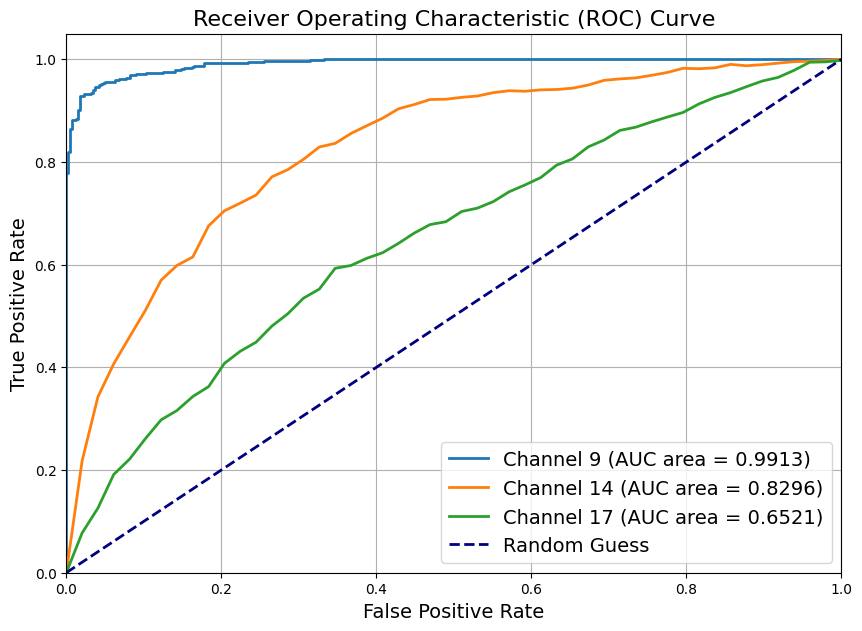

In [89]:
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import make_interp_spline

plt.figure(figsize=(10, 7))

for ch in [9, 14, 17]:
    y_true, y_score = roc_data[ch]
    y_score_column = [row[1] for row in y_score]
    fpr, tpr, _ = roc_curve(y_true, y_score_column)
    roc_auc = auc(fpr, tpr)


     # Remove duplicates from fpr and corresponding tpr
    if ch == 14 or ch == 17:
        fpr, indices = np.unique(fpr, return_index=True)
        tpr = tpr[indices]

        fpr_smooth = np.linspace(fpr.min(), fpr.max(), 50)  # Increase resolution
        tpr_smooth = make_interp_spline(fpr, tpr)(fpr_smooth)
        plt.plot(fpr_smooth, tpr_smooth, lw=2, label=f'Channel {ch} (AUC area = {roc_auc:.4f})')
    else:
        plt.plot(fpr, tpr, lw=2, label=f'Channel {ch} (AUC area = {roc_auc:.4f})')


    # Plot ROC curve with detailed annotations

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.savefig('ROC_curve_classification_combined_feature_set.png')


In [83]:
summary = []

for ch, data in channel_metrics.items():

    avg_accuracy = round(np.mean(data['accuracy'])*100,2)

    mean_report = average_classification_reports(channel_metrics[ch]['classification_report'])

    con_matrix = data['confusion_matrix']
    
    SPE_val = np.round(con_matrix[1,1] / (con_matrix[1,1] + con_matrix[1,0]) * 100, 2)     # Specificity  :  TN / (TN + FP)

    summary.append({
        'Channel': ch,
        'Acc': avg_accuracy,
        'Confusion Matrix': con_matrix,
        'PPV': mean_report['Right hand']['precision'],
        'SEN': mean_report['Right hand']['recall'],
        'SPE': SPE_val,
        'F1': mean_report['Right hand']['f1-score']
    }) 

summary_df = pd.DataFrame(summary)
summary_df

summary_df.to_csv('output/classification_summary_WT.csv', index=False)